In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pystan

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [3]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser, host='/var/run/postgresql')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [4]:
query = """
SELECT * FROM echo_filtered_MICU
"""
ef = pd.read_sql_query(query, con)
ef.head()

,row_id,icustay_id,hadm_id,subject_id,age_at_intime,gender,height,weight,bmi,ethnicity,...,fl_day1_output_ml,fl_day1_balance_ml,fl_day2_input_ml,fl_day2_output_ml,fl_day2_balance_ml,fl_day3_input_ml,fl_day3_output_ml,fl_day3_balance_ml,most_recent_hadm,first_echo
0,60492,294980,161160,105,12897 days 16:59:55,F,60.0,88.0,17.184444,BLACK/AFRICAN AMERICAN,...,310.0,4740.000000,1900.000000,546.0,1354.000000,130.000000,524.0,-394.000000,1,1
1,82787,252051,145167,106,10348 days 18:35:44,M,72.0,152.0,20.612654,UNKNOWN/NOT SPECIFIED,...,2010.0,-1564.012497,973.779999,2520.0,-1546.220001,500.000000,3400.0,-2900.000000,1,1
2,70124,249202,155897,111,25166 days 04:13:59,F,67.0,118.0,18.479394,WHITE,...,20.0,5742.809568,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,77777,218740,182743,164,30172 days 15:34:05,M,71.0,154.0,21.476294,WHITE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
4,105319,252789,176764,175,-103922 days +21:47:45.290448,M,NaN,NaN,NaN,WHITE,...,2535.0,-248.250000,1019.500004,1485.0,-465.499996,860.931246,1170.0,-309.068754,1,1


In [5]:
len(ef)

1226

In [6]:
day30_mortality = ef.ea_days_after_discharge_death <= 30

In [7]:
day30_mortality.value_counts()

False    700
True     526
Name: ea_days_after_discharge_death, dtype: int64

In [8]:
ef['day30_mortality'] = day30_mortality

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age_at_intime/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    253
4    241
1    230
2    219
3    177
5    106
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    483
1    396
2    347
dtype: int64

In [12]:
model_data = ef[['ea_lv_systolic', 'ex_congestive_heart_failure'
                , 'mech_vent', 'mdrd', 'mdrd_discrete', 'mdrd_3', 'apsiii'
                , 'fl_day1_balance_ml', 'day30_mortality']].copy()
age = ef.age_at_intime/np.timedelta64('1', 'Y')
age.loc[age<0] = age.max()
model_data['age'] = age
model_data.loc[model_data.ea_lv_systolic == -50] = np.nan
model_data = model_data.dropna()
## normalize the continuous variables
for var in ['apsiii', 'age', 'fl_day1_balance_ml', 'mdrd']:
    mu = model_data[var].mean()
    std = model_data[var].std()
    model_data[var] = (model_data[var]-mu)/std
model_data['ea_lv_systolic'] = model_data.ea_lv_systolic.astype(int) + 2
model_data['ex_congestive_heart_failure'] = model_data.ex_congestive_heart_failure.astype(int)
model_data['mech_vent'] = model_data.mech_vent.astype(int)
model_data['day30_mortality'] = model_data.day30_mortality.astype(int)
model_data['mdrd_discrete'] = model_data.mdrd_discrete.astype(int) + 1
model_data['mdrd_3'] = model_data.mdrd_3.astype(int) + 1
print(len(model_data))
model_data.head()

968


,ea_lv_systolic,ex_congestive_heart_failure,mech_vent,mdrd,mdrd_discrete,mdrd_3,apsiii,fl_day1_balance_ml,day30_mortality,age
0,5,0,0,-0.366251,4,2,-0.353177,0.906966,0,-1.814349
1,3,0,1,0.937846,1,1,-0.644915,-0.858252,1,-2.236608
2,4,1,1,1.071693,1,1,1.563959,1.187767,1,0.218058
4,1,0,1,0.310132,2,1,-0.936653,-0.489819,1,1.427185
5,2,1,0,-0.515264,4,2,-0.103116,-1.129443,0,1.205720


### Model using continuous MDRD

In [13]:
data = {'N': len(model_data)
       , 'ea_lv_systolic': model_data.ea_lv_systolic
       , 'ex_congestive_heart_failure': model_data.ex_congestive_heart_failure
       , 'mech_vent': model_data.mech_vent
       , 'mdrd': model_data.mdrd
       , 'apsiii': model_data.apsiii
       , 'age': model_data.age
       , 'fluid_day1_balance': model_data.fl_day1_balance_ml
       , 'y': model_data.day30_mortality
       }

In [14]:
%%writefile 170119_model_linear_MICU_TB.stan

data{
    int<lower=0> N;
    
    int<lower=1, upper=5> ea_lv_systolic[N];
    vector[N] ex_congestive_heart_failure;
    vector[N] mech_vent;
    vector[N] mdrd;
    vector[N] apsiii;
    vector[N] age;
    vector[N] fluid_day1_balance;
    
    int<lower=0, upper=1> y[N];
}

parameters{
    real bias;
    
    vector[5] beta_ea_lv_systolic;
    real beta_ex_congestive_heart_failure;
    real beta_mech_vent;
    real beta_mdrd;
    real beta_apsiii;
    real beta_age;
    real beta_fluid;
    
    vector[5] gamma_ea_lv_systolic;
    real gamma_ex_congestive_heart_failure;
    real gamma_mech_vent;
    real gamma_mdrd;
    
    vector[5] gamma_lv_sys_by_chf;
    vector[5] gamma_lv_sys_by_mdrd;
    
}

transformed parameters {
    vector[N] y_hat;
    vector[N] beta;
    vector[N] gamma;
    
    beta = bias + beta_ea_lv_systolic[ea_lv_systolic]
        + beta_ex_congestive_heart_failure*ex_congestive_heart_failure
        + beta_mech_vent*mech_vent
        + beta_mdrd*mdrd
        + beta_apsiii*apsiii
        + beta_age*age;
    
    gamma = beta_fluid + gamma_ea_lv_systolic[ea_lv_systolic]
        + gamma_ex_congestive_heart_failure*ex_congestive_heart_failure
        + gamma_mech_vent*mech_vent
        + gamma_mdrd*mdrd
        + gamma_lv_sys_by_chf[ea_lv_systolic] .* ex_congestive_heart_failure
        + gamma_lv_sys_by_mdrd[ea_lv_systolic] .* mdrd;
    
    y_hat = beta + gamma .* fluid_day1_balance;
}

model {
    beta_ea_lv_systolic ~ normal(0,1);
    beta_ex_congestive_heart_failure ~ normal(0,1);
    beta_mech_vent ~ normal(0,1);
    beta_mdrd ~ normal(0,1);
    beta_apsiii ~ normal(0,1);
    beta_age ~ normal(0,1);
    
    beta_fluid ~ normal(0,1);
    gamma_ea_lv_systolic ~ normal(0,1);
    gamma_ex_congestive_heart_failure ~ normal(0,1);
    gamma_mech_vent ~ normal(0,1);
    gamma_mdrd ~ normal(0,1);
    gamma_lv_sys_by_chf ~ normal(0,1);
    gamma_lv_sys_by_mdrd ~ normal(0,1);
    
    y ~ bernoulli_logit(y_hat);
}


Writing 170119_model_linear_MICU_TB.stan


In [37]:
def gamma(thetas, xs):
    gamma = thetas['beta_fluid'] + thetas['gamma_ea_lv_systolic'][:,xs.ea_lv_systolic-1].T
    gamma += np.outer(xs.ex_congestive_heart_failure, thetas['gamma_ex_congestive_heart_failure'])
    gamma += np.outer(xs.mech_vent, thetas['gamma_mech_vent'])
    gamma += np.outer(xs.mdrd, thetas['gamma_mdrd'])
    gamma += thetas['gamma_lv_sys_by_chf'][:,xs.ea_lv_systolic-1].T * xs.ex_congestive_heart_failure.values[...,np.newaxis]
    gamma += thetas['gamma_lv_sys_by_mdrd'][:,xs.ea_lv_systolic-1].T * xs.mdrd.values[...,np.newaxis]
    return gamma
    

In [38]:
def predict_linear(thetas, xs):
    beta = thetas['bias'] + thetas['beta_ea_lv_systolic'][:,xs.ea_lv_systolic-1].T
    beta += np.outer(xs.ex_congestive_heart_failure, thetas['beta_ex_congestive_heart_failure'])
    beta += np.outer(xs.mech_vent, thetas['beta_mech_vent'])
    beta += np.outer(xs.mdrd, thetas['beta_mdrd'])
    beta += np.outer(xs.apsiii, thetas['beta_apsiii'])
    beta += np.outer(xs.age, thetas['beta_age'])
    
    return beta + gamma(thetas, xs)*xs.fl_day1_balance_ml.values[...,np.newaxis]


In [16]:
#compile the model
model_linear = pystan.StanModel(file='170119_model_linear_MICU_TB.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad5783dcbe3fd6194c76e203866cd702 NOW.


In [17]:
#fit the model
model_fit = model_linear.sampling(data, chains=1, iter=4000, algorithm='NUTS')

In [18]:
model_fit

Inference for Stan model: anon_model_ad5783dcbe3fd6194c76e203866cd702.
1 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=2000.

                                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
bias                               -0.29    0.02   0.47  -1.23  -0.61  -0.28   0.04   0.63  660.0    1.0
beta_ea_lv_systolic[0]              0.15    0.02   0.48  -0.77  -0.18   0.14   0.48    1.1  875.0    1.0
beta_ea_lv_systolic[1]             -0.19    0.02   0.47  -1.09  -0.51   -0.2   0.13   0.77  543.0    1.0
beta_ea_lv_systolic[2]             -0.42    0.02   0.49  -1.36  -0.75  -0.42  -0.08   0.52  906.0    1.0
beta_ea_lv_systolic[3]             -0.05    0.02   0.51   -1.0  -0.41  -0.06   0.29   0.99  974.0    1.0
beta_ea_lv_systolic[4]              0.43    0.02   0.48  -0.48    0.1   0.43   0.74   1.41  894.0    1.0
beta_ex_congestive_heart_failure    0.07  3.5e-3   0.15  -0.23  -0.04   0.07

### Take a look at model accuracy

In [19]:
y_hats = model_fit.extract('y_hat')
y_hats = pd.DataFrame(y_hats['y_hat'])
y_hats.head()

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
0,0.923131,-0.377757,2.192893,-0.069033,-1.181348,-0.737319,-0.101409,0.761168,-0.865803,-1.532586,...,-1.269490,-0.412343,0.313118,0.991332,1.136804,-1.091617,-1.577627,0.480745,-0.585635,4.659021
1,0.331230,-1.628941,0.104994,0.133880,-0.586734,-0.915114,-0.366539,1.173814,-0.713956,-1.501210,...,-0.938477,-0.245313,0.175799,0.958957,1.287701,-1.400966,-2.041762,0.186222,-1.038084,2.965407
2,0.199492,-0.873543,1.964255,0.186443,-1.484356,-1.592769,-0.227642,0.909467,-1.309756,-1.932422,...,-1.689971,-0.912135,0.693709,0.529657,0.967725,-2.658992,-1.889422,0.534905,-0.684262,2.565060
3,0.909855,-1.890189,2.072325,-0.316602,-0.349933,-2.241647,-0.171394,0.707733,-1.015489,-1.184288,...,-0.769583,-0.512083,0.452503,-0.387736,1.300950,-1.965190,-1.530660,0.766608,-0.793166,2.910740
4,0.382930,-0.982127,1.557085,0.055764,-0.325268,-0.619840,-0.016085,1.336357,-0.809469,-1.711389,...,-0.808852,-0.575713,0.919155,1.112427,1.224275,-2.339484,-1.682463,0.533983,-0.884072,3.351352


In [20]:
y_hat_mu = y_hats.mean()

In [21]:
y_hat_p = 1./(1+np.exp(-y_hat_mu))

In [22]:
((y_hat_p >= 0.5) == model_data.day30_mortality).mean()

0.68595041322314054

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

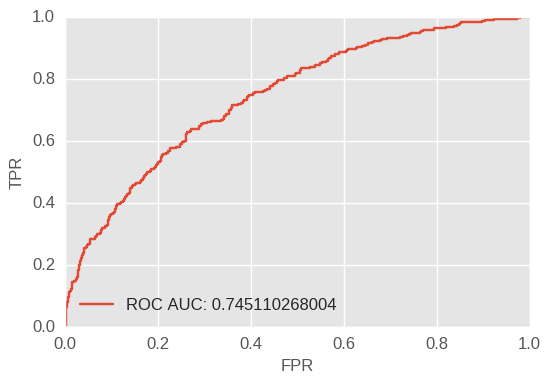

In [24]:
fpr, tpr, _ = roc_curve(model_data.day30_mortality, y_hat_mu)
aucroc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC AUC: {}'.format(aucroc))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')

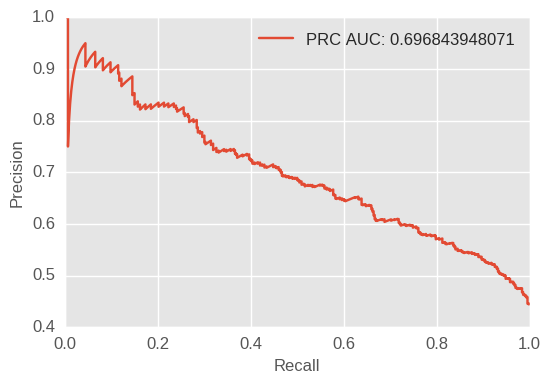

In [25]:
prec, rec, _ = precision_recall_curve(model_data.day30_mortality, y_hat_mu)
aucprc = auc(rec, prec)
plt.plot(rec, prec, label='PRC AUC: {}'.format(aucprc))
plt.legend(loc='best')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [26]:
def threshold_accuracy(y_true, y_pred):
    I = y_pred.argsort()
    y_true = y_true[I]
    y_pred = y_pred[I]
    tru = np.cumsum(y_true[::-1])[::-1]
    fls = np.cumsum(1-y_true) - 1
    cor = tru+fls
    acc = cor / float(len(y_pred))
    return acc, y_pred, y_true

0.689049586777 -0.169000444948


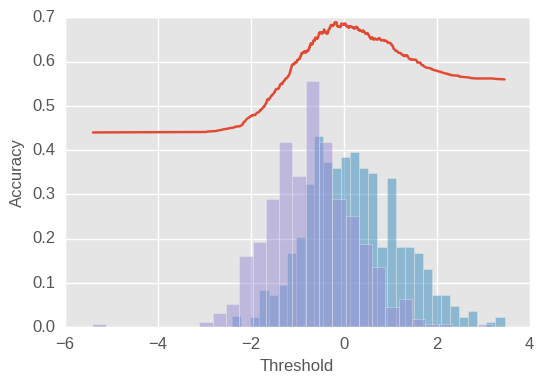

In [27]:
acc, thresh, label = threshold_accuracy(model_data.day30_mortality.values, y_hat_mu.values)
i = np.argmax(acc)
print(acc[i], thresh[i])
plt.plot(thresh, acc)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.hist(thresh[label==1], normed=True, alpha=0.5, bins=30)
plt.hist(thresh[label==0], normed=True, alpha=0.5, bins=30)
pass

In [28]:
model_data.day30_mortality.mean()

0.44008264462809915

### Plot some prediction vs fluid balance curves

In [29]:
thetas_linear = model_fit.extract(['bias', 'beta_ea_lv_systolic', 'beta_ex_congestive_heart_failure'
                                          , 'beta_mech_vent', 'beta_mdrd', 'beta_apsiii', 'beta_age', 'beta_fluid'
                                          , 'gamma_ea_lv_systolic', 'gamma_ex_congestive_heart_failure'
                                          , 'gamma_mech_vent', 'gamma_mdrd', 'gamma_lv_sys_by_chf'
                                          , 'gamma_lv_sys_by_mdrd'])

In [30]:
flags = ['ex_congestive_heart_failure', 'ea_lv_systolic', 'mech_vent', 'mdrd', 'apsiii', 'age']

def predict_quantiles(fluid_range, df, as_logit=True):
    fluid_df = pd.DataFrame({'fl_day1_balance_ml': fluid_range})
    df = df.copy()
    del df['day30_mortality']
    del df['mdrd_discrete']
    del df['mdrd_3']
    
    q = [2.5, 50., 97.5]
    quants = np.zeros((len(fluid_range), 1+len(q)))
    for i,fl in enumerate(fluid_range):
        df['fl_day1_balance_ml'] = fl
        yh = predict_linear(thetas_linear, df)
        if not as_logit:
            yh = 1./(1. + np.exp(-yh))
        quants[i,0] = np.mean(yh)
        quants[i,1:] = np.percentile(yh, q)
    
    return quants

In [31]:
mi, ma = model_data.fl_day1_balance_ml.min(), model_data.fl_day1_balance_ml.max()
fluid_range = np.linspace(mi, ma, 100)
def df_predict_quantiles(df):
    q = predict_quantiles(fluid_range, df)
    return pd.DataFrame(q)
chf_quantiles = model_data.groupby('ex_congestive_heart_failure').apply(df_predict_quantiles)
chf_quantiles.reset_index(level=0, inplace=True)
chf_quantiles.head()

,ex_congestive_heart_failure,0,1,2,3
0,0,-1.711306,-12.515243,-1.217432,6.118210
1,0,-1.688032,-12.309757,-1.205293,6.023448
2,0,-1.664759,-12.102155,-1.192604,5.929096
3,0,-1.641486,-11.899041,-1.180361,5.833657
4,0,-1.618213,-11.695845,-1.167615,5.738699


In [32]:
def df_predict_quantiles_p(df):
    q = predict_quantiles(fluid_range, df, as_logit=False)
    return pd.DataFrame(q)
chf_p_quantiles = model_data.groupby('ex_congestive_heart_failure').apply(df_predict_quantiles_p)
chf_p_quantiles.reset_index(level=0, inplace=True)
chf_p_quantiles.head()

,ex_congestive_heart_failure,0,1,2,3
0,0,0.396768,0.000004,0.228389,0.997802
1,0,0.396247,0.000005,0.230535,0.997585
2,0,0.395723,0.000006,0.232794,0.997346
3,0,0.395197,0.000007,0.234987,0.997081
4,0,0.394669,0.000008,0.237286,0.996791


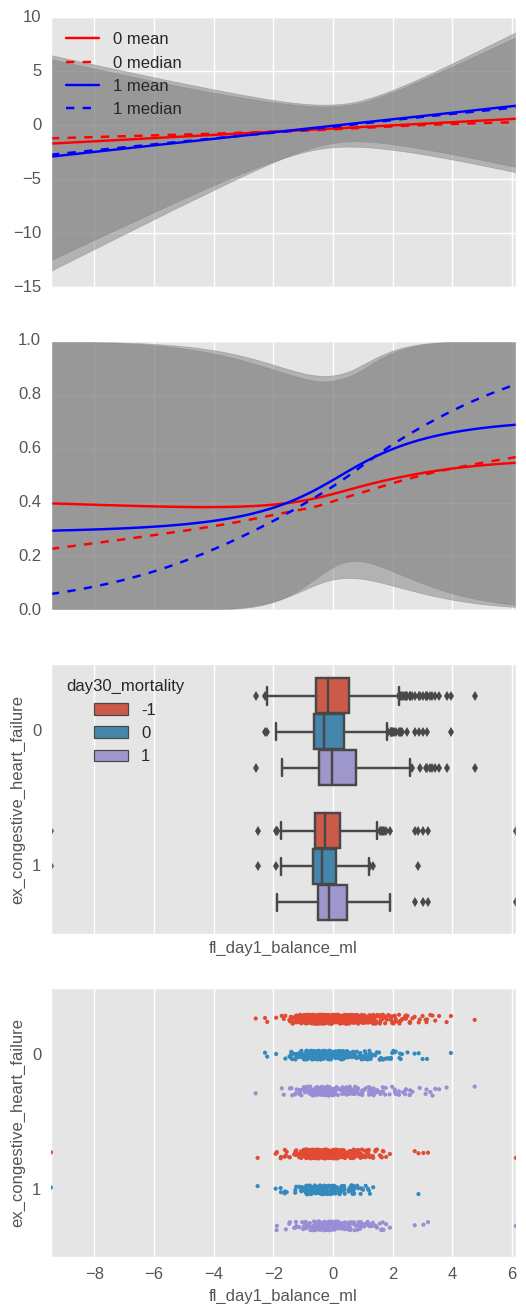

In [33]:
fig, ax = plt.subplots(4, figsize=(6, 16), sharex=True)
color = ['r', 'b']
for flag,df in chf_quantiles.groupby('ex_congestive_heart_failure'):
    quants = df[[0,1,2,3]].values #, as_logit=False)
    mu = quants[:,0]
    lo = quants[:,1]
    med = quants[:,2]
    hi = quants[:,3]
    ax[0].plot(fluid_range, mu, color[flag], label=str(flag) + ' mean')
    ax[0].plot(fluid_range, med, '--'+color[flag], label=str(flag) + ' median')
    ax[0].fill_between(fluid_range, hi, lo, color='gray', alpha=0.5)
    #md_flag = model_data.loc[model_data.ex_congestive_heart_failure == flag]
    #ax[1].hist(md_flag.fl_day1_balance_ml, normed=True, alpha=0.5, bins=20)
    #for f2,mddf in md_flag.groupby('day30_mortality'):
    #    ax[2].hist(mddf.fl_day1_balance_ml, normed=True, bottom=f2, alpha=0.5
    #               , label='CHF: '+str(flag)+', Mortality:'+str(f2))
    #ax[2].plot(md_flag.fl_day1_balance_ml, md_flag.day30_mortality, '.', label=flag)
for flag,df in chf_p_quantiles.groupby('ex_congestive_heart_failure'):
    quants = df[[0,1,2,3]].values #, as_logit=False)
    mu = quants[:,0]
    lo = quants[:,1]
    med = quants[:,2]
    hi = quants[:,3]
    ax[1].plot(fluid_range, mu, color[flag], label=str(flag) + ' mean')
    ax[1].plot(fluid_range, med, '--'+color[flag], label=str(flag) + ' median')
    ax[1].fill_between(fluid_range, hi, lo, color='gray', alpha=0.5)    
ax[0].legend(loc='best')
_ = ax[0].set_xlim((mi, ma))
#_ = ax[0].set_ylim((-6, 20))

to_plot = model_data.copy()
to_plot['day30_mortality'] = -1
to_plot = pd.concat([to_plot, model_data], axis=0)
sns.boxplot(ax=ax[2], data=to_plot, y='ex_congestive_heart_failure', x='fl_day1_balance_ml', hue='day30_mortality'
           , orient='h')
sns.stripplot(ax=ax[3], x='fl_day1_balance_ml', y='ex_congestive_heart_failure', hue='day30_mortality'
              ,data=to_plot, split=True, jitter=True, size=3, linewidth=0, orient='h')
_ = ax[3].legend().set_visible(False)

### Take a look at the posteriors of some of the parameters

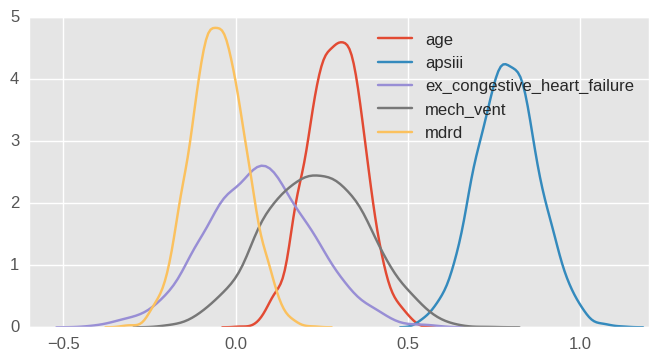

In [34]:
factors = model_fit.extract(['beta_age', 'beta_apsiii', 'beta_ex_congestive_heart_failure', 'beta_mech_vent'
                            , 'beta_mdrd'])
plt.figure(figsize=(8, 4))
for key in ['age', 'apsiii', 'ex_congestive_heart_failure', 'mech_vent', 'mdrd']:
    sns.kdeplot(factors['beta_'+key], label=key)
plt.legend(loc='best')

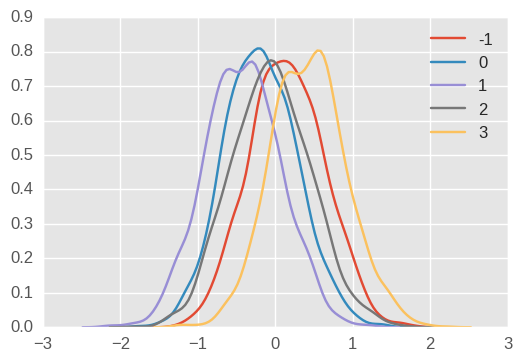

In [35]:
beta_lv_sys = model_fit.extract('beta_ea_lv_systolic')['beta_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(beta_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

(0.20997222248550093, 0.51108332810243684, 0.1751785562621877)

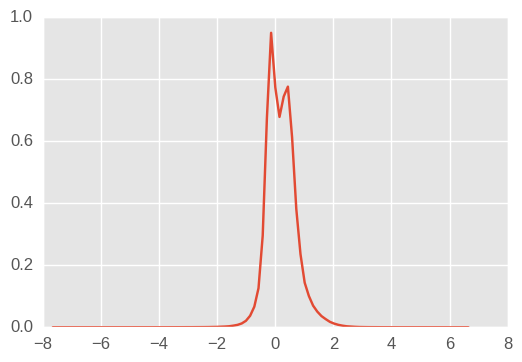

In [42]:
## calculate the marginal parameter on the fluids term
gamma_marginal = gamma(thetas_linear, model_data)
sns.kdeplot(gamma_marginal.ravel())
gamma_marginal.mean(), gamma_marginal.std(), np.percentile(gamma_marginal, 50)

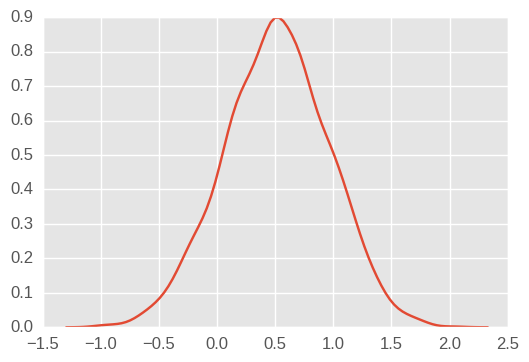

In [36]:
sns.kdeplot(model_fit.extract('beta_fluid')['beta_fluid'])

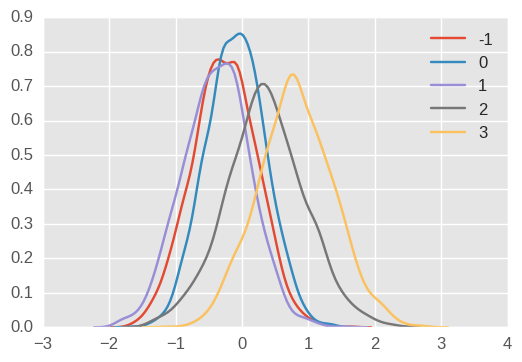

In [43]:
gamma_lv_sys = model_fit.extract('gamma_ea_lv_systolic')['gamma_ea_lv_systolic']
for i in range(5):
    sns.kdeplot(gamma_lv_sys[:,i], label=str(i-1))
plt.legend(loc='best')

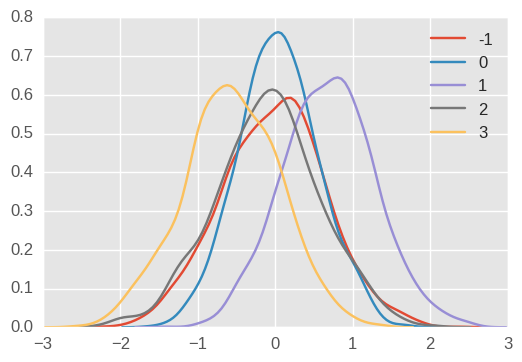

In [44]:
gamma_lv_sys_by_chf = model_fit.extract('gamma_lv_sys_by_chf')['gamma_lv_sys_by_chf']
for i in range(5):
    sns.kdeplot(gamma_lv_sys_by_chf[:,i], label=str(i-1))
plt.legend(loc='best')

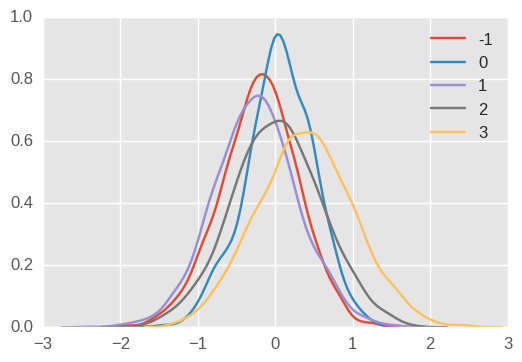

In [45]:
gamma_lv_sys_by_mdrd = model_fit.extract('gamma_lv_sys_by_mdrd')['gamma_lv_sys_by_mdrd']
for i in range(5):
    sns.kdeplot(gamma_lv_sys_by_mdrd[:,i], label=str(i-1))
plt.legend(loc='best')